In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, Dataset, ConcatDataset
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

# Calculo de similaridade
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cityblock
from sklearn.metrics import jaccard_score

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Define seed
SEED = 42

# Set the seed for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
torch.backends.cudnn.benchmark = False    # Disable if you want deterministic results

Feature_ambos = [
                #'L4_SRC_PORT',
                #'L4_DST_PORT',
                'PROTOCOL',
                #'L7_PROTO',
                'IN_BYTES',
                'IN_PKTS',
                'OUT_BYTES',
                'OUT_PKTS',
                #'TCP_FLAGS',
                #'CLIENT_TCP_FLAGS',
                #'SERVER_TCP_FLAGS',
                'FLOW_DURATION_MILLISECONDS',
                'DURATION_IN', 
                'DURATION_OUT',
                #'MIN_TTL', 
                #'MAX_TTL',
                'LONGEST_FLOW_PKT',
                #'SHORTEST_FLOW_PKT',
                #'MIN_IP_PKT_LEN', 
                'MAX_IP_PKT_LEN', 
                'SRC_TO_DST_SECOND_BYTES', 
                'DST_TO_SRC_SECOND_BYTES',
                'RETRANSMITTED_IN_BYTES', 
                'RETRANSMITTED_IN_PKTS', 
                'RETRANSMITTED_OUT_BYTES', 
                'RETRANSMITTED_OUT_PKTS',
                'SRC_TO_DST_AVG_THROUGHPUT', 
                'DST_TO_SRC_AVG_THROUGHPUT', 
                'NUM_PKTS_UP_TO_128_BYTES',
                'NUM_PKTS_128_TO_256_BYTES', 
                'NUM_PKTS_256_TO_512_BYTES', 
                'NUM_PKTS_512_TO_1024_BYTES',
                'NUM_PKTS_1024_TO_1514_BYTES', 
                #'TCP_WIN_MAX_IN', 
                #'TCP_WIN_MAX_OUT', 
                'ICMP_TYPE', 
                'ICMP_IPV4_TYPE',
                #'DNS_QUERY_ID', 
                'DNS_QUERY_TYPE', 
                #'DNS_TTL_ANSWER',
                #'FTP_COMMAND_RET_CODE',
                'Label', 
                'Attack']

Feature_name = [f for f in Feature_ambos if f not in ['Label', 'Attack']]

input_dim = 26

# Mapear todos os ataques
map_attacks = {'Benign':0, 
              'DoS':1,
              'dos':1,
              'Reconnaissance':2,
              'DDoS':3,
              'ddos':3,
              'Theft':4,
              'ransomware':5,
              'scanning':6,
              'xss':7,
              'mitm':8,
              'password':9,
              'Backdoor':10,
              'backdoor':10,
              'Analysis':11,
              'Generic':12,
              'Exploits':13,
              'Bot':14,
              'DoS_attacks-SlowHTTPTest':15,
              'SSH-Bruteforce':16,
              'DoS_attacks-Hulk':17,
              'Infilteration':18,
              'DDOS_attack-HOIC':19, 
              'FTP-BruteForce':20,
              'Brute_Force_-Web':21, 
              'DDoS_attacks-LOIC-HTTP':22, 
              'DoS_attacks-GoldenEye':23,
              'DDOS_attack-LOIC-UDP':24, 
              'DoS_attacks-Slowloris':25, 
              'Brute_Force_-XSS':26,
              'SQL_Injection':27
              }

In [2]:
class MLP(nn.Module):
    def __init__(self, latent_dim):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Dropout(0.3),

            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.mlp(x)

In [3]:
def get_datasets(dataset):
    
    if dataset == "dataset1":
         df = pd.read_csv('datasets/dataset1v2.csv') # NF-BoT-IoT-v2
    if dataset == "dataset2":
         df = pd.read_csv('datasets/dataset2v2.csv') # NF-ToN-IoT-v2
    if dataset == "dataset3":
         df = pd.read_csv('datasets/dataset3v2.csv') # NF-UNSW-NB15-v2
    if dataset == "dataset4":
         df = pd.read_csv('datasets/dataset4v2.csv') # NF-CICIDS2018-v3

    dataframe = df[Feature_ambos]
    
    return dataframe

In [4]:
def tensor_data(x_source1_train, y_source1_train):
    previsores_train = torch.tensor(np.array(x_source1_train), dtype = torch.float)
    class_train = torch.tensor(np.array(y_source1_train, dtype=np.float32), dtype = torch.float)
    dataset = torch.utils.data.TensorDataset(previsores_train, class_train)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=41)
    return previsores_train, class_train, dataset, train_loader

In [5]:
def inicia_datasets(treino):
      df = get_datasets(treino)
      print(f"Prepara {treino}: {df.shape}")
      x_split_train, y_split_train, x_split_val, y_split_val, x_split_test, y_split_test, z_split_test = preprocessing_data(df)
      print( x_split_train.shape, y_split_train.shape)
      print( x_split_val.shape, y_split_val.shape)
      print( x_split_test.shape, y_split_test.shape)
      dataset_train, class_train, dataset_train, loader_train = tensor_data( x_split_train,  y_split_train)
      dataset_val, class_val, dataset_val, loader_val = tensor_data( x_split_val,  y_split_val)
      dataset_test, class_test, dataset_test, loader_test = tensor_data( x_split_test,  y_split_test)
      return dataset_train, class_train, dataset_train, loader_train, dataset_val, class_val, dataset_val, loader_val, dataset_test, class_test, dataset_test, loader_test, z_split_test

In [29]:
def preprocessing_data(df):
    df_split = df.copy()
    df_split_label = df_split['Attack']
    df_split = df_split.drop('Attack',axis=1)
    df_split = df_split.drop('Label',axis=1)
    
    # Inicializando o MinMaxScaler (intervalo padrão é [0, 1])
    scaler = MinMaxScaler()

    # Ajustando e transformando os dados
    df_split = scaler.fit_transform(df_split)
    
    df_split_label = df_split_label.to_frame()
    x_split_train, x_split_temp, y_split_train, y_split_temp = train_test_split(df_split, df_split_label, test_size = 0.30, stratify=df_split_label)
    x_split_test, x_split_val, y_split_test, y_split_val = train_test_split(x_split_temp, y_split_temp, test_size = 0.50, stratify=y_split_temp)
    y_split_train['Attack'] = y_split_train['Attack'].apply(lambda x: 0 if x == 'Benign' else 1)
    z_split_test = y_split_test.copy()
    y_split_test['Attack'] = y_split_test['Attack'].apply(lambda x: 0 if x == 'Benign' else 1)
    #print(z_split_test)
    z_split_test['Attack']=z_split_test['Attack'].map(map_attacks)
    #z_test = torch.tensor(np.array(z_split_test, dtype=np.float32), dtype = torch.float)
    class_test = torch.tensor(np.array(y_split_test, dtype=np.float32), dtype = torch.float)
    class_attack = torch.tensor(np.array(z_split_test, dtype=np.float32), dtype = torch.float)
    dataset = torch.utils.data.TensorDataset(class_attack, class_test)
    z_test = torch.utils.data.DataLoader(dataset, batch_size=41)
    #print(z_split_test)
    y_split_val['Attack'] = y_split_val['Attack'].apply(lambda x: 0 if x == 'Benign' else 1)
    return x_split_train, y_split_train, x_split_val, y_split_val, x_split_test, y_split_test, z_test

In [30]:
dataset = "dataset1" 
dataset_train1, class_train1, dataset_train1, loader_train1, dataset_val1, class_val1, dataset_val1, loader_val1, dataset_test1, class_test1, dataset_test1, loader_test1, z_split_test1 = inicia_datasets(dataset)
dataset = "dataset2" 
dataset_train2, class_train2, dataset_train2, loader_train2, dataset_val2, class_val2, dataset_val2, loader_val2, dataset_test2, class_test2, dataset_test2, loader_test2, z_split_test2 = inicia_datasets(dataset)
dataset = "dataset3" 
dataset_train3, class_train3, dataset_train3, loader_train3, dataset_val3, class_val3, dataset_val3, loader_val3, dataset_test3, class_test3, dataset_test3, loader_test3, z_split_test3 = inicia_datasets(dataset)
dataset = "dataset4" 
dataset_train4, class_train4, dataset_train4, loader_train4, dataset_val4, class_val4, dataset_val4, loader_val4, dataset_test4, class_test4, dataset_test4, loader_test4, z_split_test4 = inicia_datasets(dataset)

# Gerar ambos para teste e validação
test_dataset_combined = ConcatDataset([dataset_test1, dataset_test2, dataset_test3, dataset_test4])
test_loader_combined = DataLoader(test_dataset_combined, batch_size=loader_test1.batch_size, shuffle=True)
val_dataset_combined = ConcatDataset([dataset_val1, dataset_val2, dataset_val3, dataset_val4])
val_loader_combined = DataLoader(val_dataset_combined, batch_size=loader_val1.batch_size, shuffle=True)


Prepara dataset1: (224511, 28)
                Attack
55331             DDoS
183305          Benign
171664            DDoS
82102             DDoS
46720           Benign
...                ...
171081          Benign
81312   Reconnaissance
3094    Reconnaissance
88495           Benign
46968             DDoS

[33677 rows x 1 columns]
        Attack
55331        3
183305       0
171664       3
82102        3
46720        0
...        ...
171081       0
81312        2
3094         2
88495        0
46968        3

[33677 rows x 1 columns]
(157157, 26) (157157, 1)
(33677, 26) (33677, 1)
(33677, 26) (33677, 1)
Prepara dataset2: (224512, 28)
          Attack
138589    Benign
157761      mitm
20299     Benign
185161  password
91525   backdoor
...          ...
189070    Benign
77201     Benign
117218  password
26912     Benign
70539     Benign

[33677 rows x 1 columns]
        Attack
138589       0
157761       8
20299        0
185161       9
91525       10
...        ...
189070       0
77201    

In [8]:
def treina_modelo(modelo_MLP, input_dim, device):

    from sklearn.metrics import classification_report
    
    # Hiperparâmetros
    num_classes = 2
    epochs = 500
    lr = 0.001

    Alpha = 0.5
    Beta = 1
    
    patience = 50
    best_val_acc = 0
    epochs_no_improve = 0
    best_model_state = None
  
    # Otimizador conjunto
    params = list(modelo_MLP.parameters())
    optimizer = torch.optim.Adam(params, lr=lr)

    # Scheduler: reduz o learning rate se a acurácia parar de melhorar
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=10, factor=0.5)

    # Funções de perda
    class_loss_fn = nn.BCEWithLogitsLoss()

    # Histórico
    loss_vals = []
    loss_valsAE = []
    loss_valsAE2 = []
    loss_valsAE3 = []
    loss_valsMLP = []
    val_simC = []
    val_distE = []
    val_distM = []
    val_accuracies = []
    val_losses = []

    for epoch in range(epochs):
        
        modelo_MLP.train()

        epoch_loss_recon = []
        epoch_loss_class = []
        epoch_loss_val = []
        epoch_simC = []
        epoch_corr = []
        epoch_distE = []
        epoch_distM = []
        epoch_simJ = []
        
        # Variaveis para similaridade
        simC = 0  # Cosseno 
        corr = 0  # Pearson 1.0 Correlação perfeita
        distE = 0  #  Eculidiana - Distância euclidiana
        distM = 0  # Distância de Manhattan
        simJ = 0  # Similaridade de Jaccard (para vetores binários ou conjuntos)

        for (X1, y1), (X2, y2), (X3, y3), (X4, y4) in zip(loader_train1, loader_train2, loader_train3, loader_train4):
    
            X = torch.cat([X1, X2, X3, X4], dim=0).to(device)
            y = torch.cat([y1, y2, y3, y4], dim=0).to(device).float()
            y = y.view(-1, 1)
            
            optimizer.zero_grad()
            
            outputs = modelo_MLP(X)
            loss_class = F.binary_cross_entropy(outputs, y)

            total_loss = loss_class

            total_loss.backward()
            optimizer.step()

            epoch_loss_class.append(loss_class.item())
       
        # === Logs da época ===
        loss_epoch_class = sum(epoch_loss_class) / len(epoch_loss_class)
        
        loss_valsMLP.append(loss_epoch_class)
        
        print(f"Epoch {epoch+1:02d}/{epochs} | Class: {loss_epoch_class:.4f}")

        modelo_MLP.eval()
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            
           for (X1, y1), (X2, y2), (X3, y3), (X4, y4) in zip(loader_val1, loader_val2, loader_val3, loader_val4):
    
               X = torch.cat([X1, X2, X3, X4], dim=0).to(device)
               y = torch.cat([y1, y2, y3, y4], dim=0).to(device).float()
               y = y.view(-1, 1)
            
               optimizer.zero_grad()
            
               # Classificação
               outputs = modelo_MLP(X)
               loss_class = F.binary_cross_entropy(outputs, y)
               
               preds = (outputs > 0.5).float()

               # Calcula loss (BCE para binário)
               loss = F.binary_cross_entropy(outputs, y)
               
               epoch_loss_val.append(loss.item())
               
               all_preds.append(preds.cpu())
               all_labels.append(y.cpu())

        all_preds_list = torch.cat(all_preds)
        all_labels_list = torch.cat(all_labels)
        acc = (all_preds_list.view(-1) == all_labels_list.view(-1)).float().mean().item()
        loss_val = sum(epoch_loss_val) / len(epoch_loss_val)
    
        val_accuracies.append(acc)
        val_losses.append(loss_val)
        print(f"Acurácia: {acc}")

        # Atualiza scheduler com base na acurácia de validação
        scheduler.step(acc)

        # Mostra o learning rate atual
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        print(f"Learning Rate atual: {current_lr:.6f}")        

        # Early stopping
        if acc > best_val_acc:
            best_val_acc = acc
            epochs_no_improve = 0
            best_model_state = modelo_MLP.state_dict()
        else:
            epochs_no_improve += 1
            print(f"Sem melhoria na validação por {epochs_no_improve} época(s).")
            if epochs_no_improve >= patience:
                print(f"Early stopping ativado na época {epoch+1}")
                break

    # Restaurar melhor modelo
    if best_model_state is not None:
        modelo_MLP.load_state_dict(best_model_state)
        print("Melhor modelo MLP restaurado com base na menor perda de validação.")  
        
    # === Plots ===
    plt.plot(loss_valsMLP, label='MLP')
    plt.title('Treinamento - Perdas')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.plot(val_losses, label='MLP')
    plt.title('Validação: Perdas')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Acurácia
    plt.subplot(1,2,2)
    plt.plot(val_accuracies, label='Validação', color='green')
    plt.title('Validação: Acurácia x Época')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return  all_preds, all_labels

In [9]:
# Instanciando o modelo
modelo_MLP = MLP(input_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Epoch 01/500 | Class: 0.4561
Acurácia: 0.8293445706367493
Learning Rate atual: 0.001000
Epoch 02/500 | Class: 0.3661
Acurácia: 0.7668079733848572
Learning Rate atual: 0.001000
Sem melhoria na validação por 1 época(s).
Epoch 03/500 | Class: 0.3283
Acurácia: 0.7773341536521912
Learning Rate atual: 0.001000
Sem melhoria na validação por 2 época(s).
Epoch 04/500 | Class: 0.3111
Acurácia: 0.861321210861206
Learning Rate atual: 0.001000
Epoch 05/500 | Class: 0.3020
Acurácia: 0.7760930061340332
Learning Rate atual: 0.001000
Sem melhoria na validação por 1 época(s).
Epoch 06/500 | Class: 0.2963
Acurácia: 0.8672927021980286
Learning Rate atual: 0.001000
Epoch 07/500 | Class: 0.2902
Acurácia: 0.8707936406135559
Learning Rate atual: 0.001000
Epoch 08/500 | Class: 0.2861
Acurácia: 0.8719761967658997
Learning Rate atual: 0.001000
Epoch 09/500 | Class: 0.2832
Acurácia: 0.8710277676582336
Learning Rate atual: 0.001000
Sem melhoria na validação por 1 época(s).
Epoch 10/500 | Class: 0.2802
Acurácia: 0.

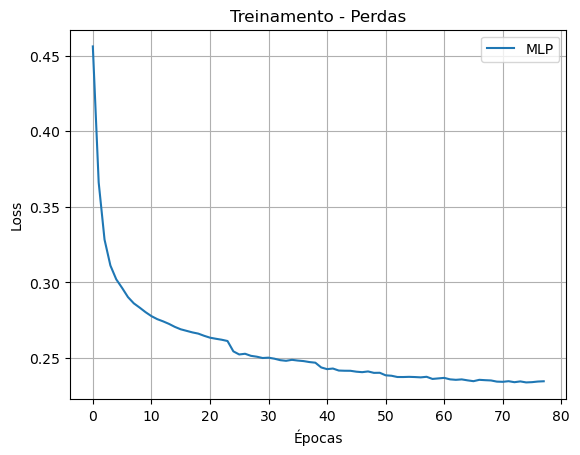

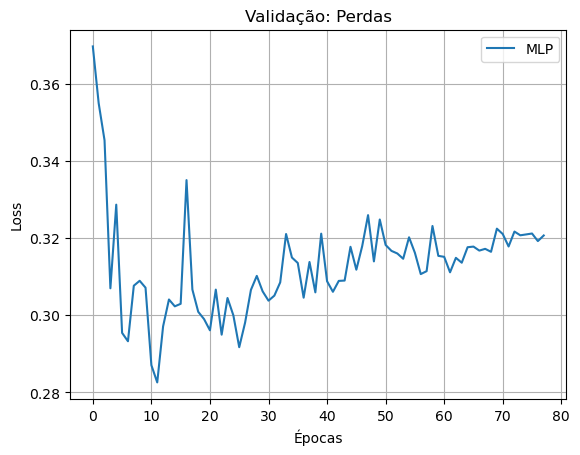

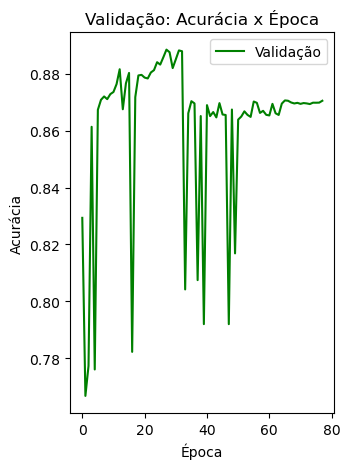

In [10]:
train_preds, train_labels = treina_modelo(modelo_MLP, input_dim, device)

In [11]:
def testa(target_test, treino, labels_test):
  # Valida source
  modelo_MLP.eval()
  all_preds, all_labels, all_attacks = [], [], []

  # print(labels_test)

  with torch.no_grad():
      
    for (X, y), (z, y2) in zip(target_test, labels_test):

         X = X.to(device)
         y = y.to(device).float()
         y = y.view(-1, 1)
         z = z.to(device).float()
         z = z.view(-1, 1)
         #print("Len y: ",len(y))
         #print("Len z: ",len(z))
        
         # Classificação com vetor latente
         outputs = modelo_MLP(X)
         loss_class = F.binary_cross_entropy(outputs, y)
               
         preds = (outputs > 0.5).float()

         # Calcula loss (BCE para binário)
         loss = F.binary_cross_entropy(outputs, y)
               
         all_preds.append(preds.cpu())
         all_labels.append(y.cpu())
         all_attacks.append(z.cpu())
        
  all_preds_list = torch.cat(all_preds)
  all_labels_list = torch.cat(all_labels)
  all_attacks_list = torch.cat(all_attacks)
  #print(len(all_labels_list))
  #print(len(all_attacks_list))

  acc = (all_preds_list.view(-1) == all_labels_list.view(-1)).float().mean().item()

  # Matriz de confusão
  matriz2 = confusion_matrix(all_preds_list.numpy().round(), all_labels_list.numpy().round())
  sns.set(rc={"figure.figsize": (6, 6)})
  title = "Matriz de Confusão: " + treino
  sns.heatmap(matriz2/np.sum(matriz2), annot=True, annot_kws={'size': 10}, fmt='.2%', cmap='Blues').set_title(title)
  plt.show()

  # Extração dos elementos da matriz (para problema binário)
  TN, FP, FN, TP = matriz2.ravel()

  # Cálculo das métricas
  TPR = TP / (TP + FN) if (TP + FN) != 0 else 0  # Sensibilidade, Recall
  TNR = TN / (TN + FP) if (TN + FP) != 0 else 0  # Especificidade
  F1 = f1_score(all_labels_list.detach().numpy().round(), all_preds_list.detach().numpy().round())
  return TPR, TNR, F1, acc, all_preds_list.view(-1), all_labels_list.view(-1), all_attacks_list.view(-1)

Treinando com Ambos e validando com dataset1


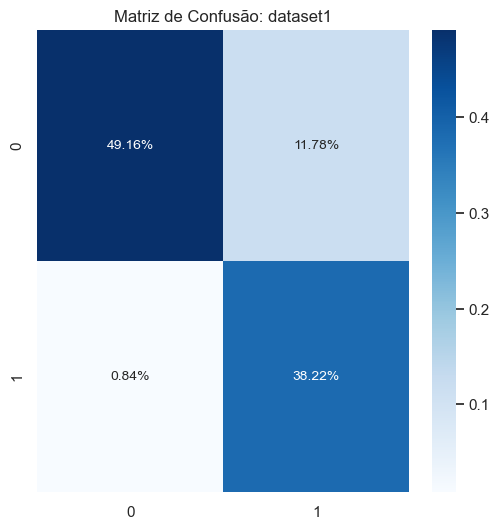

Treinando com Ambos e validando com dataset2


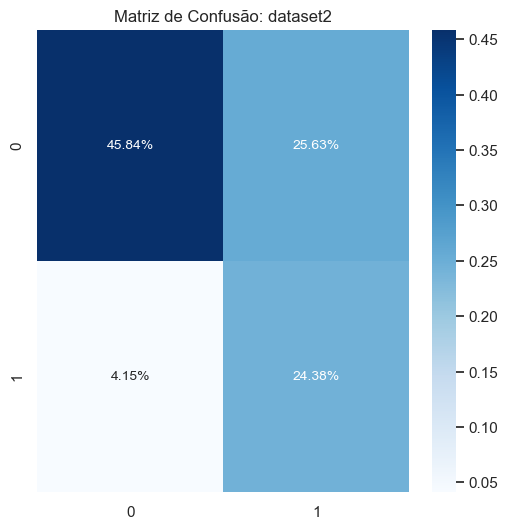

Treinando com Ambos e validando com dataset3


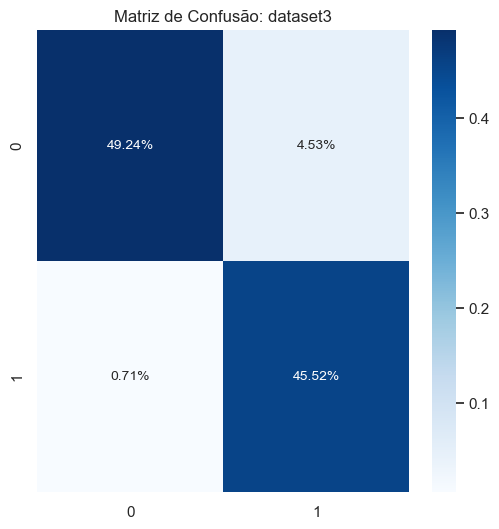

Treinando com Ambos e validando com dataset4


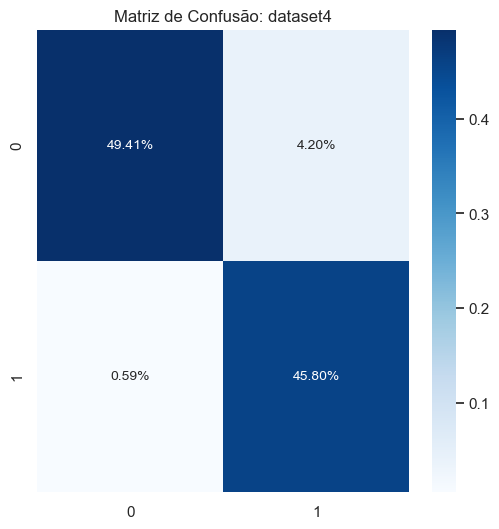

----------------------------------------------
Resumo da validação nos Datasets:
    Dataset       TPR       TNR  F1-Score  Acurácia
0  dataset1  0.978484  0.806665  0.858257  0.873771
1  dataset2  0.854392  0.641448  0.620789  0.702200
2  dataset3  0.984682  0.915744  0.945594  0.947615
3  dataset4  0.987296  0.921710  0.950346  0.952137
----------------------------------------------


In [12]:
datasets = ["dataset1", "dataset2", "dataset3", "dataset4"]
target_test = [loader_test1, loader_test2, loader_test3, loader_test4]
labels_test = [z_split_test1, z_split_test2, z_split_test3, z_split_test4]

TPRs = []
TNRs = []
F1s = []
ACCs = []
all_preds_lists = []
all_labels_lists = []
all_attacks_lists = []
for data, teste, labels  in zip(datasets, target_test, labels_test):
    print(f"Treinando com Ambos e validando com {data}")
    TPR, TNR, F1, acc, all_preds_list, all_labels_list, all_attacks_list = testa(teste, data, labels)
    TPRs.append(TPR)
    TNRs.append(TNR)
    F1s.append(F1)
    ACCs.append(acc)
    all_preds_lists.extend(all_preds_list)
    all_labels_lists.extend(all_labels_list)
    all_attacks_lists.extend(all_attacks_list)
# Criação da tabela
df = pd.DataFrame({
    'Dataset': datasets,
    'TPR': TPRs,
    'TNR': TNRs,
    'F1-Score': F1s,
    'Acurácia': ACCs
})
print("----------------------------------------------")
print("Resumo da validação nos Datasets:")
print(df)
print("----------------------------------------------")

In [13]:
print(len(all_labels_lists))
print(len(all_preds_lists))
print(len(all_attacks_lists))

122273
122273
122273


In [37]:
# Combinar todas as predições em um dataframe para tabulação

all_labels = [t.item() for t in all_labels_lists]
all_preds = [t.item() for t in all_preds_lists]
all_attacks = [t.item() for t in all_attacks_lists]

# Inverter dicionario
map_attacks_inv = {v: k for k, v in map_attacks.items()}

df = pd.DataFrame({
    "Real": all_labels,
    "Previsto": all_preds,
    "Ataque": all_attacks
})

# Criar coluna de acerto/erro
df["Acertou"] = df["Real"] == df["Previsto"]

# Agrupar predições por tipo de ataque
tabela = df.groupby("Ataque").agg(
    Total=("Real","count"),
    Acertos=("Acertou","sum")
)

# Adicionar Acurácia por ataque
tabela["Acurácia"] = tabela["Acertos"] / tabela["Total"]

# Adicionar F1 por ataque
f1_por_ataque = {}
TP_por_ataque = {}
TN_por_ataque = {}
FP_por_ataque = {}
FN_por_ataque = {}
for atk, grupo in df.groupby("Ataque"):
    f1_por_ataque[atk] = f1_score(grupo["Real"], grupo["Previsto"], zero_division=0)
    TP_por_ataque[atk] = ((grupo["Real"] == 1) & (grupo["Previsto"] == 1)).sum()
    TN_por_ataque[atk] = ((grupo["Real"] == 0) & (grupo["Previsto"] == 0)).sum()
    FP_por_ataque[atk] = ((grupo["Real"] == 0) & (grupo["Previsto"] == 1)).sum()
    FN_por_ataque[atk] = ((grupo["Real"] == 1) & (grupo["Previsto"] == 0)).sum()

tabela["TP"] = tabela.index.map(TP_por_ataque)
tabela["TN"] = tabela.index.map(TN_por_ataque)
tabela["FP"] = tabela.index.map(FP_por_ataque)
tabela["FN"] = tabela.index.map(FN_por_ataque)
tabela["F1"] = tabela.index.map(f1_por_ataque)


# Renomear indice pelo nome do ataque
tabela.index = tabela.index.map(map_attacks_inv)

print("Resumo por tipo de ataque:")
print(tabela)

Resumo por tipo de ataque:
                          Total  Acertos  Acurácia    TP     TN    FP    FN  \
Ataque                                                                        
Benign                    61125    59094  0.966773     0  59094  2031     0   
dos                        8527     6286  0.737188  6286      0     0  2241   
Reconnaissance             7409     3447  0.465245  3447      0     0  3962   
ddos                       9825     7081  0.720712  7081      0     0  2744   
Theft                       364      180  0.494505   180      0     0   184   
ransomware                  514      397  0.772374   397      0     0   117   
scanning                   2166       18  0.008310    18      0     0  2148   
xss                        2167     1602  0.739271  1602      0     0   565   
mitm                       1158      361  0.311744   361      0     0   797   
password                   2167     1649  0.760960  1649      0     0   518   
backdoor                 